In [6]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

def xsigmoid(x):
    y=x/(1+tf.math.exp(-x))
    return y

def preprocess(Data,max_norm=1,min_norm=0):
    #normalization
    Data = (Data - Data.min())/(Data.max() - Data.min())*(max_norm - min_norm) + min_norm
    # for i in range(len(Data.columns)):
    #     Data[Data.columns[i]] = (Data[Data.columns[i]] - Data[Data.columns[i]].mean())/Data[Data.columns[i]].std()
    #     print('standardized')
    #standardization
    #for i in range(len(Data.columns)):
    #    if Data[Data.columns[i]].std()*3 > (Data[Data.columns[i]].max()-Data[Data.columns[i]].min()):
    #        Data[Data.columns[i]] = (Data[Data.columns[i]] - Data[Data.columns[i]].mean())/Data[Data.columns[i]].std()
    #        print('standardized %d'%i)
    #    else:
    #        Data = (Data - Data.min())/(Data.max() - Data.min())*(max_norm - min_norm) + min_norm
    return Data

Data = pd.read_csv(r'D:\Desktop\case3_one_signal.csv')
Data = preprocess(Data)
# Data = np.log(Data)

X = pd.DataFrame(Data,columns=['x1','x2','x3'])
Y = Data[Data.columns[-1:]]

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=42)

x_train = x_train.values.tolist()
x_test = x_test.values.tolist()
y_train = y_train.values.tolist()
y_test = y_test.values.tolist()

n = 7  # 뉴런 개수
n_layer = 4 #네트워크 레이어 개수
diag_act_f = tf.nn.sigmoid  #대각행렬 레이어 활성화 함수
act_f = tf.nn.elu           #액티베이션 함수
initializer = tf.keras.initializers.he_normal()
# initializer = tf.keras.initializers.glorot_normal()
xavier_init = tf.keras.initializers.glorot_normal()
he_init = tf.keras.initializers.he_normal()
# he_init = tf.truncated_normal
l_rate = 0.001 #러닝 레이트
t_step = 100000 #트레이닝 스텝
input_n = len(x_train[0]) #인풋 뉴런 개수
num_output = 1

# a = tf.constant([0.5,0.5,0.5,0.5,0.5,0.5,0.5])
# # b = tf.constant([1.5,1.5,1.5,1.5,1.5])
C = tf.Variable([0.5,0.5,0.5])
mask = np.array([1,1,1])
# C = tf.constant([0.5,0.3,0.7])
C = tf.clip_by_value(C,0,1)
C = C*mask
# C = tf.boolean_mask(C,mask)
C = tf.diag(C)
C_layer  = tf.matmul(x_train,C)
test_C_layer = tf.matmul(x_test,C)

# C = tf.Variable([0.5,0.5,0.5,0.5,0.5])
# mask = tf.constant([True,True,True])
# C = tf.boolean_mask(C,mask)
# C = tf.clip_by_value(C,0,1)
# C = tf.diag(C)
# C_layer = act_f(tf.matmul(x_train, C))
# test_C_layer = act_f(tf.matmul(x_test, C))

W1 = tf.Variable(initializer([input_n,n]))
#         b1 = tf.Variable(initializer([n]))
layer1out = act_f(tf.matmul(C_layer, W1) )
test_layer1out = act_f(tf.matmul(test_C_layer, W1) )


for i in range(n_layer-1):

    globals()['W{}'.format(i+2)] = tf.Variable(initializer([n,n]))
#             globals()['b{}'.format(i+2)] = tf.Variable(initializer([n]))
    globals()['layer{}out'.format(i+2)] = act_f(tf.matmul(globals()['layer{}out'.format(i+1)], globals()['W{}'.format(i+2)]))
    globals()['test_layer{}out'.format(i+2)] = act_f(tf.matmul(globals()['test_layer{}out'.format(i+1)], globals()['W{}'.format(i+2)]))

# model layer

M_W = tf.Variable(initializer([n,num_output]))
# M_b = tf.Variable(initializer([1]))
M_layerout = tf.matmul(globals()['layer{}out'.format(n_layer)], M_W)
test_M_layerout = tf.matmul(globals()['test_layer{}out'.format(n_layer)], M_W)

### training algorithm

# loss_kl_train = tf.reduce_mean(tf.abs(y_data*tf.math.log(M_layerout/y_data)))
# loss_kl_test = tf.reduce_mean(tf.abs(y_test*tf.math.log(test_M_layerout/y_test)))
# loss_train = tf.sqrt(tf.reduce_mean((tf.square(y_train - M_layerout))))/(100*tf.reduce_mean(2*tf.math.abs(C-a))) 
# loss_test  = tf.sqrt(tf.reduce_mean((tf.square(y_test - test_M_layerout))))/(100*tf.reduce_mean(2*tf.math.abs(C-a)))
loss_train = tf.sqrt(tf.reduce_mean((tf.square(y_train - M_layerout))))
loss_test  = tf.sqrt(tf.reduce_mean((tf.square(y_test - test_M_layerout))))

#         loss0 = tf.sqrt(tf.reduce_mean((tf.square(y_train[0] - test_M_layerout[0]))))
#         loss1 = tf.sqrt(tf.reduce_mean((tf.square(y_train[1] - test_M_layerout[1]))))
#         loss2 = tf.sqrt(tf.reduce_mean((tf.square(y_train[2] - test_M_layerout[2]))))
# loss_grid_train = tf.reduce_mean(g*tf.math.abs((y_data - M_layerout)/local_volume_data))/tf.reduce_sum(local_volume_data)
# loss_grid_test = tf.reduce_mean(g*tf.math.abs((y_test - test_M_layerout)/local_volume_test))/tf.reduce_sum(local_volume_test)
train = tf.train.AdamOptimizer(l_rate).minimize(loss_train)
Weight = []
rmse = []
test_rmse = []
sess = tf.Session()

for k in range(100):
    
    sess.run(tf.global_variables_initializer())

    # while math.isnan(sess.run(loss_kl_train)) == True:
    #     sess.run(tf.global_variables_initializer())

    for step in range(t_step):

        sess.run(train)


        ### save bset value

        if step == 0:
            best_value = sess.run(loss_test)
            over_num = 0

        else:   
            if best_value >= sess.run(loss_test):

                over_num = 0
                best_value = sess.run(loss_test)
                best_value1= sess.run(loss_train)
                matrix = sess.run(C)

            if best_value < sess.run(loss_test):
                over_num += 1

        if over_num == 100:
            print('over fitting occurs!')
            break

        if (step+1) % 10000 == 0:

            print(step+1, 'steps    loss : ', sess.run(loss_train))
#             rmse.append(sess.run(loss_train))
#             test_rmse.append(sess.run(loss_test))

    #     if (step+1) % 100 == 0:
    #         train_rmse.append(sess.run(loss_train))
    #         test_rmse.append(sess.run(loss_test))

        # if sess.run(loss_train) <= 1.0e-06:

        #     break

    print('training complete!   loss : ', best_value1)
    print('validation loss : ', best_value)
#     globals()['matrix_array{}'.format(k+1)] = [matrix[i][i] for i in range(len(matrix))]
#     if sess.run(loss_test) < 0.001:
    rmse.append(sess.run(loss_test))
    num_weight = [matrix[i][i] for i in range(len(matrix))]
    Weight.append(num_weight)

10000 steps    loss :  0.0017059013
20000 steps    loss :  0.0013911516
30000 steps    loss :  0.0012176484
40000 steps    loss :  0.0010563966
50000 steps    loss :  0.0009847598
60000 steps    loss :  0.0009457229
over fitting occurs!
training complete!   loss :  0.00094062416
validation loss :  0.0008987004
10000 steps    loss :  0.0016288462
20000 steps    loss :  0.0014212315
30000 steps    loss :  0.0013223533
40000 steps    loss :  0.0012473746
50000 steps    loss :  0.0011823471
60000 steps    loss :  0.0011234878
70000 steps    loss :  0.0010724734
80000 steps    loss :  0.0010329142
over fitting occurs!
training complete!   loss :  0.0010275289
validation loss :  0.0010954025
10000 steps    loss :  0.0015764469
20000 steps    loss :  0.0013732614
30000 steps    loss :  0.0012981727
40000 steps    loss :  0.0012465995
50000 steps    loss :  0.0012097558
60000 steps    loss :  0.0011824406
70000 steps    loss :  0.0011603375
80000 steps    loss :  0.0011410092
90000 steps    lo

10000 steps    loss :  0.0027339086
20000 steps    loss :  0.002151747
30000 steps    loss :  0.0018299324
over fitting occurs!
training complete!   loss :  0.0017677508
validation loss :  0.0018908033
10000 steps    loss :  0.004314959
20000 steps    loss :  0.0032792962
30000 steps    loss :  0.002720031
40000 steps    loss :  0.0024798748
50000 steps    loss :  0.0022831634
60000 steps    loss :  0.002123741
70000 steps    loss :  0.0019636548
80000 steps    loss :  0.00184513
90000 steps    loss :  0.0017618466
100000 steps    loss :  0.001700874
training complete!   loss :  0.001700741
validation loss :  0.0018734628
10000 steps    loss :  0.0014774657
20000 steps    loss :  0.001116845
30000 steps    loss :  0.0009687178
40000 steps    loss :  0.00091603934
over fitting occurs!
training complete!   loss :  0.0008934241
validation loss :  0.00093251304
10000 steps    loss :  0.0015681855
over fitting occurs!
training complete!   loss :  0.0014840818
validation loss :  0.0016180935

90000 steps    loss :  0.0013081357
100000 steps    loss :  0.0012774453
training complete!   loss :  0.0012774122
validation loss :  0.001324106
10000 steps    loss :  0.0032229342
20000 steps    loss :  0.0028825274
30000 steps    loss :  0.0027128195
40000 steps    loss :  0.0025937946
50000 steps    loss :  0.0024937366
60000 steps    loss :  0.0024061112
70000 steps    loss :  0.002321785
80000 steps    loss :  0.002220745
90000 steps    loss :  0.0021133197
100000 steps    loss :  0.0020113662
training complete!   loss :  0.0020124952
validation loss :  0.002093898
10000 steps    loss :  0.0025005245
20000 steps    loss :  0.0019402932
30000 steps    loss :  0.0016950015
40000 steps    loss :  0.0015701695
50000 steps    loss :  0.0014918274
60000 steps    loss :  0.0014344335
70000 steps    loss :  0.0013907538
80000 steps    loss :  0.0013550908
90000 steps    loss :  0.0013244908
100000 steps    loss :  0.0012972256
training complete!   loss :  0.0012980577
validation loss :  

10000 steps    loss :  0.0021166736
over fitting occurs!
training complete!   loss :  0.0018596277
validation loss :  0.0021765558
10000 steps    loss :  0.0033106857
20000 steps    loss :  0.0025023646
30000 steps    loss :  0.0022041914
40000 steps    loss :  0.0020363524
50000 steps    loss :  0.0019078534
60000 steps    loss :  0.001793
over fitting occurs!
training complete!   loss :  0.0017440482
validation loss :  0.0018528401
10000 steps    loss :  0.0016704984
20000 steps    loss :  0.001267705
over fitting occurs!
training complete!   loss :  0.0011999987
validation loss :  0.0012866926
over fitting occurs!
training complete!   loss :  0.0014528862
validation loss :  0.0014850753
10000 steps    loss :  0.0016820701
20000 steps    loss :  0.0013497096
over fitting occurs!
training complete!   loss :  0.0012363922
validation loss :  0.0013020312
10000 steps    loss :  0.0030059165
20000 steps    loss :  0.0023403366
30000 steps    loss :  0.0018969752
40000 steps    loss :  0.0

In [7]:
a,b,c = 0,0,0

for i in range(len(Weight)):
    a += Weight[i][0]
    b += Weight[i][1]
    c += Weight[i][2]
#     d += Weight[i][3]
#     e += Weight[i][4]
#     f += Weight[i][5]
#     g += Weight[i][6]

a = a/len(Weight)
b = b/len(Weight)
c = c/len(Weight)
# d = d/len(Weight)
# e = e/len(Weight)
# f = f/len(Weight)
# g = g/len(Weight)

avg_rmse = 0
for i in range(len(rmse)):
    avg_rmse += rmse[i]
avg_rmse = avg_rmse/len(rmse)
avg_rmse

0.0015363613289082422

In [8]:
print(a)
print(b)
print(c)
# print(d)
# print(e)
# print(f)
# print(g)

0.2108963991329074
0.5192350980639457
0.49640994787216186


<BarContainer object of 3 artists>

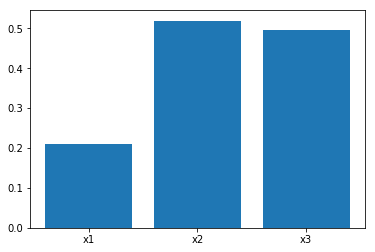

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(['x1','x2','x3'],[a,b,c])

[0, 1, 0, 1]

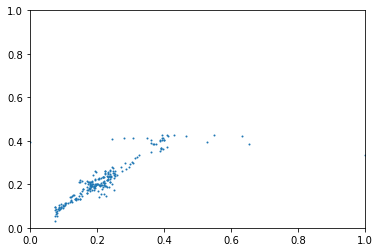

In [92]:
plt.scatter(y_train,sess.run(M_layerout),s=1)
plt.axis([0,1,0,1])

In [208]:
sess.run(tf.global_variables_initializer())
mask = tf.constant([False,False,True])
for step in range(t_step):

    sess.run(train)


    ### save bset value

    if step == 0:
        best_value = sess.run(loss_test)
        over_num = 0

    else:   
        if best_value >= sess.run(loss_test):

            over_num = 0
            best_value = sess.run(loss_test)
            best_value1= sess.run(loss_train)
            matrix = sess.run(C)

        if best_value < sess.run(loss_test):
            over_num += 1

    if over_num == 100:
        print('over fitting occurs!')
        break

    if (step+1) % 1000 == 0:

        print(step+1, 'steps    loss : ', sess.run(loss_train))
        rmse.append(sess.run(loss_train))
        test_rmse.append(sess.run(loss_test))

#     if (step+1) % 100 == 0:
#         train_rmse.append(sess.run(loss_train))
#         test_rmse.append(sess.run(loss_test))

    # if sess.run(loss_train) <= 1.0e-06:

    #     break+

print('training complete!   loss : ', best_value1)
print('validation loss : ', best_value)
globals()['matrix_array{}'.format(k+1)] = [matrix[i][i] for i in range(len(matrix))]

1000 steps    loss :  0.000570678
2000 steps    loss :  0.000254177
3000 steps    loss :  0.00016071614
4000 steps    loss :  9.8519835e-05
5000 steps    loss :  5.4541637e-05
training complete!   loss :  5.4541637e-05
validation loss :  5.0505758e-05


In [207]:
matrix

array([[0.3029862, 0.       , 0.       ],
       [0.       , 1.       , 0.       ],
       [0.       , 0.       , 1.       ]], dtype=float32)

In [209]:
x = ['x1','x2','x3','x4','x5']
# matrix_array3 = [matrix[i][i] for i in range(len(matrix))]
# matrix_array3

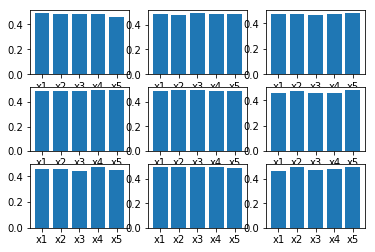

In [214]:
fig = plt.figure()
for i in range(9):
    globals()['ax{}'.format(i+1)] = fig.add_subplot(3,3,i+1)
# for i in range(9):
    globals()['ax{}'.format(i+1)].bar(x,globals()['matrix_array{}'.format(i+1)])
    
# ax1.bar(x,matrix_array1)
plt.show()

(0, 0.1)

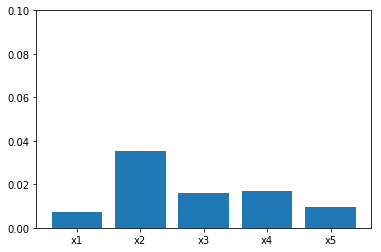

In [184]:
plt.bar(x,[0.007429602,	0.035413071,	0.016135933,	0.016819385,	0.009784405
])
plt.ylim([0,0.1])

c:\users\user\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


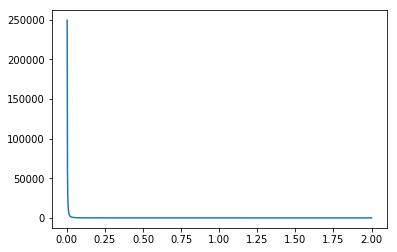

In [140]:
b = 1/(a*a)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(a,b)

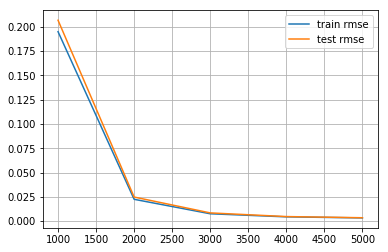

In [168]:
import matplotlib.pyplot as plt
%matplotlib inline
aa = [1000,2000,3000,4000,5000]
plt.plot(aa,rmse,label='train rmse')
plt.plot(aa,test_rmse,label='test rmse')
plt.legend(loc='upper right')
plt.grid(True)

<BarContainer object of 5 artists>

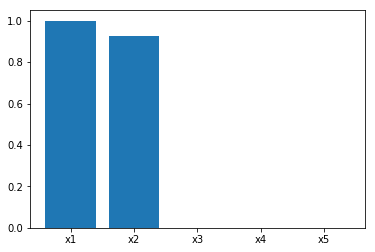

In [172]:
y = [1,0.92564,0,0,0]
x = ['x1','x2','x3','x4','x5']
plt.bar(x,y)

In [166]:
len(rmse)

5

In [11]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

def xsigmoid(x):
    y=x/(1+tf.math.exp(-x))
    return y

def preprocess(Data,max_norm=1,min_norm=0):
    #normalization
    Data = (Data - Data.min())/(Data.max() - Data.min())*(max_norm - min_norm) + min_norm
    # for i in range(len(Data.columns)):
    #     Data[Data.columns[i]] = (Data[Data.columns[i]] - Data[Data.columns[i]].mean())/Data[Data.columns[i]].std()
    #     print('standardized')
    #standardization
    #for i in range(len(Data.columns)):
    #    if Data[Data.columns[i]].std()*3 > (Data[Data.columns[i]].max()-Data[Data.columns[i]].min()):
    #        Data[Data.columns[i]] = (Data[Data.columns[i]] - Data[Data.columns[i]].mean())/Data[Data.columns[i]].std()
    #        print('standardized %d'%i)
    #    else:
    #        Data = (Data - Data.min())/(Data.max() - Data.min())*(max_norm - min_norm) + min_norm
    return Data

Data = pd.read_csv(r'D:\Desktop\case2_one_signal.csv')
Data = preprocess(Data)
# Data = np.log(Data)

X = Data[Data.columns[:-1]]
Y = Data[Data.columns[-1:]]

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=42)

x_train = x_train.values.tolist()
x_test = x_test.values.tolist()
y_train = y_train.values.tolist()
y_test = y_test.values.tolist()

n = 3  # 뉴런 개수
n_layer = 5 #네트워크 레이어 개수
diag_act_f = tf.nn.sigmoid  #대각행렬 레이어 활성화 함수
act_f = tf.nn.elu          #액티베이션 함수
initializer = tf.keras.initializers.he_normal()
xavier_init = tf.keras.initializers.glorot_normal()
he_init = tf.keras.initializers.he_normal()
# he_init = tf.truncated_normal
l_rate = 0.001 #러닝 레이트
t_step = 100000 #트레이닝 스텝
input_n = len(x_train[0]) #인풋 뉴런 개수
num_output = 1
C_init = [0.5,0.5,0.5]
Weight = []

for k in range(20):
    
    # a = tf.constant([0.5,0.5,0.5])
    # # b = tf.constant([1.5,1.5,1.5,1.5,1.5])
    C = tf.Variable(C_init)
    # mask = tf.constant([True,True,True])
    # C = tf.boolean_mask(C,mask)
    # C = tf.constant([0.5,0.3,0.7])
    C = tf.clip_by_value(C,0,1)
    C = tf.diag(C)
    C_layer  = tf.matmul(x_train,C)
    test_C_layer = tf.matmul(x_test,C)

    # C = tf.Variable([0.5,0.5,0.5,0.5,0.5])
    # mask = tf.constant([True,True,True])
    # C = tf.boolean_mask(C,mask)
    # C = tf.clip_by_value(C,0,1)
    # C = tf.diag(C)
    # C_layer = act_f(tf.matmul(x_train, C))
    # test_C_layer = act_f(tf.matmul(x_test, C))

    W1 = tf.Variable(initializer([input_n,n]))
    #         b1 = tf.Variable(initializer([n]))
    layer1out = act_f(tf.matmul(C_layer, W1) )
    test_layer1out = act_f(tf.matmul(test_C_layer, W1) )


    for i in range(n_layer-1):

        globals()['W{}'.format(i+2)] = tf.Variable(initializer([n,n]))
    #             globals()['b{}'.format(i+2)] = tf.Variable(initializer([n]))
        globals()['layer{}out'.format(i+2)] = act_f(tf.matmul(globals()['layer{}out'.format(i+1)], globals()['W{}'.format(i+2)]))
        globals()['test_layer{}out'.format(i+2)] = act_f(tf.matmul(globals()['test_layer{}out'.format(i+1)], globals()['W{}'.format(i+2)]))

    # model layer

    M_W = tf.Variable(initializer([n,num_output]))
    # M_b = tf.Variable(initializer([1]))
    M_layerout = tf.matmul(globals()['layer{}out'.format(n_layer)], M_W)
    test_M_layerout = tf.matmul(globals()['test_layer{}out'.format(n_layer)], M_W)

    ### training algorithm

    # loss_kl_train = tf.reduce_mean(tf.abs(y_data*tf.math.log(M_layerout/y_data)))
    # loss_kl_test = tf.reduce_mean(tf.abs(y_test*tf.math.log(test_M_layerout/y_test)))
    # loss_train = tf.sqrt(tf.reduce_mean((tf.square(y_train - M_layerout))))/(100*tf.reduce_mean(tf.math.abs(C-a))) 
    # loss_test  = tf.sqrt(tf.reduce_mean((tf.square(y_test - test_M_layerout))))/(100*tf.reduce_mean(tf.math.abs(C-a)))
    loss_train = tf.sqrt(tf.reduce_mean((tf.square(y_train - M_layerout))))
    loss_test  = tf.sqrt(tf.reduce_mean((tf.square(y_test - test_M_layerout))))

    #         loss0 = tf.sqrt(tf.reduce_mean((tf.square(y_train[0] - test_M_layerout[0]))))
    #         loss1 = tf.sqrt(tf.reduce_mean((tf.square(y_train[1] - test_M_layerout[1]))))
    #         loss2 = tf.sqrt(tf.reduce_mean((tf.square(y_train[2] - test_M_layerout[2]))))
    # loss_grid_train = tf.reduce_mean(g*tf.math.abs((y_data - M_layerout)/local_volume_data))/tf.reduce_sum(local_volume_data)
    # loss_grid_test = tf.reduce_mean(g*tf.math.abs((y_test - test_M_layerout)/local_volume_test))/tf.reduce_sum(local_volume_test)
    train = tf.train.AdamOptimizer(l_rate).minimize(loss_train)
    
    rmse = []
    test_rmse = []
    sess = tf.Session()

    sess.run(tf.global_variables_initializer())

    # while math.isnan(sess.run(loss_kl_train)) == True:
    #     sess.run(tf.global_variables_initializer())

    for step in range(t_step):

        sess.run(train)


        ### save bset value

        if step == 0:
            best_value = sess.run(loss_test)
            over_num = 0

        else:   
            if best_value >= sess.run(loss_test):

                over_num = 0
                best_value = sess.run(loss_test)
                best_value1= sess.run(loss_train)
                matrix = sess.run(C)

            if best_value < sess.run(loss_test):
                over_num += 1

        if over_num == 100:
            print('over fitting occurs!')
            break

        if (step+1) % 10000 == 0:

            print(step+1, 'steps    loss : ', sess.run(loss_train))
            rmse.append(sess.run(loss_train))
            test_rmse.append(sess.run(loss_test))

    #     if (step+1) % 100 == 0:
    #         train_rmse.append(sess.run(loss_train))
    #         test_rmse.append(sess.run(loss_test))

        # if sess.run(loss_train) <= 1.0e-06:

        #     break

    print('training complete!   loss : ', best_value1)
    print('validation loss : ', best_value)
    globals()['matrix_array{}'.format(k+1)] = [matrix[i][i] for i in range(len(matrix))]
    num_weight = [matrix[i][i] for i in range(len(matrix))]
    Weight.append(num_weight)
    C_init = num_weight

10000 steps    loss :  0.0016570747
20000 steps    loss :  0.0012885415
30000 steps    loss :  0.0012137298
over fitting occurs!
training complete!   loss :  0.001203854
validation loss :  0.0011805864
10000 steps    loss :  0.00070767035
over fitting occurs!
training complete!   loss :  0.0006723114
validation loss :  0.0006538865
10000 steps    loss :  0.00359822
20000 steps    loss :  0.0027111585
30000 steps    loss :  0.0023568026
40000 steps    loss :  0.002149589
over fitting occurs!
training complete!   loss :  0.0021324283
validation loss :  0.0021040516
10000 steps    loss :  0.00059672684
over fitting occurs!
training complete!   loss :  0.00057582266
validation loss :  0.000559629
over fitting occurs!
training complete!   loss :  0.001376127
validation loss :  0.0013496178
10000 steps    loss :  0.0010028797
20000 steps    loss :  0.0009193206
over fitting occurs!
training complete!   loss :  0.00090393936
validation loss :  0.0008789104
10000 steps    loss :  0.0021346027


In [4]:
len(Weight)

20

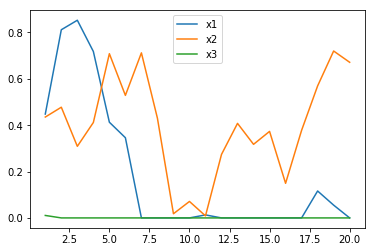

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
a = [Weight[i][0] for i in range(len(Weight))]
b = [Weight[i][1] for i in range(len(Weight))]
c = [Weight[i][2] for i in range(len(Weight))]
x = [i+1 for i in range(20)]
plt.plot(x,a)
plt.plot(x,b)
plt.plot(x,c)
plt.legend(['x1','x2','x3'])
plt.show()